In [126]:
import folium
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import squarify 
import pandas as pd
from matplotlib.sankey import Sankey
import seaborn as sns
import time

In [439]:
def load_census_data(directory):
    # Load census data from given directory
    df = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.csv'):
            df_temp = pd.read_csv(os.path.join(directory,filename),skiprows=1)
            df_temp["Year_ID"] = filename[:4] + df_temp['Id2'].map(str)
            df_temp = df_temp.set_index("Year_ID")
            df.append(df_temp)


    census_data = pd.concat(df)
    return census_data
def load_drug_data():
    
    census_data = load_census_data("data/census_data_2013/")
    
    drug_data = pd.read_excel('data/drug_data.xlsx', sheet_name = "Data")
    drug_data = drug_data[drug_data["YYYY"] >= 2013]
    drug_data["Year_ID"] = drug_data["YYYY"].map(str) + drug_data["FIPS_Combined"].map(str)
    drug_data = drug_data.set_index("Year_ID")
    fips = drug_data["FIPS_Combined"].map(str).apply(lambda x: x[2:])[~drug_data.index.duplicated()]
    state = drug_data[["State","YYYY"]][~drug_data.index.duplicated()]
    drug_piv = drug_data.pivot(columns="SubstanceName", values=["DrugReports"])

    drug_piv[["TotalDrugReportsCounty","TotalDrugReportsState"]] = drug_data.drop_duplicates(subset=["TotalDrugReportsCounty","TotalDrugReportsState"])[["TotalDrugReportsCounty","TotalDrugReportsState"]]
    
    drug_piv["Total"] = drug_piv["DrugReports"].sum(axis=1).fillna(0)
    drug_piv["FIPS"] = fips
    drug_piv[["State","Year"]] = state
    drug_piv["DrugReportsPerCapita"] = drug_piv["Total"]/census_data["Estimate; RELATIONSHIP - Population in households"]
    return drug_piv

drug_data = load_drug_data()



/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [377]:
#Inputs:
#state='KY','WV','OH','VA', or 'PA'
#year=2013,2014,2015, or 2016
#Type='Total','DrugReportsPerCapita'
#filename=''
def CreateStateMap(state,year,Type,filename=None):
    #Sets Topojson and coordinates for inputted state
    if (state == "KY"):
        STATE = os.path.join('data', 'KY-21-kentucky-counties.json')
        TOPOS = 'objects.cb_2015_kentucky_county_20m'
        Cords = [37.494283, -85.445286]
    elif (state == "WV"):
        STATE = os.path.join('data', 'WV-54-west-virginia-counties.json')
        TOPOS = 'objects.cb_2015_west_virginia_county_20m'
        Cords = [38.90, -80.95]
    elif (state == "OH"):
        STATE = os.path.join('data', 'OH-39-ohio-counties.json')
        TOPOS = 'objects.cb_2015_ohio_county_20m'
        Cords = [40.25, -82.50]
    elif (state == "VA"):
        STATE = os.path.join('data', 'VA-51-virginia-counties.json')
        TOPOS = 'objects.cb_2015_virginia_county_20m'
        Cords = [37.728, -79.40]
    else:
        STATE = os.path.join('data', 'PA-42-pennsylvania-counties.json')
        TOPOS = 'objects.cb_2015_pennsylvania_county_20m'
        Cords = [40.81, -77.827679]

    #Create Map 
    M = folium.Map(
    location = Cords,
    zoom_start=8,
    tiles='cartodbpositron'
    )
    
    #Pull correct data
    DATA = drug_data[(drug_data["State"]==state) & (drug_data["Year"]==year)]
    
    #Create layer
    folium.Choropleth(
        open(STATE),
        topojson = TOPOS,
        data=DATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 319, 638, 957, 1276, 1595, 1914],
        highlight = True
        ).add_to(M)
    
    #save file if wanted
    if (filename):
        M.save(outfile=filename)
        
    #Output map
    return M
        
#CreateStateMap(state,year,Type,filename=None)       

In [438]:
#Inputs:
#year=2013,2014,2015, or 2016
#Type='Total','DrugReportsPerCapita'
#filename=''
def CreateAllStatesMap(year,Type,filename=None):
    #Sets Topojson and coordinates for states
    KENT = os.path.join('data', 'KY-21-kentucky-counties.json')
    WESTV = os.path.join('data', 'WV-54-west-virginia-counties.json')
    OHIO = os.path.join('data', 'OH-39-ohio-counties.json')
    VIRG = os.path.join('data', 'VA-51-virginia-counties.json')
    PENN = os.path.join('data', 'PA-42-pennsylvania-counties.json')

    #Create Map 
    M = folium.Map(
    location = [39.25,-80.82],
    zoom_start=7,
    tiles='cartodbpositron'
    )
    
    #Pull all state data
    KENTDATA = drug_data[(drug_data["State"]=='KY') & (drug_data["Year"]==year)]
    WESTVDATA = drug_data[(drug_data["State"]=='WV') & (drug_data["Year"]==year)]
    OHIODATA = drug_data[(drug_data["State"]=='OH') & (drug_data["Year"]==year)]
    VIRGDATA = drug_data[(drug_data["State"]=='VA') & (drug_data["Year"]==year)]
    PENNDATA = drug_data[(drug_data["State"]=='PA') & (drug_data["Year"]==year)]
    
    #Create layers
    folium.Choropleth(
        open(KENT),
        topojson = 'objects.cb_2015_kentucky_county_20m',
        data=KENTDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(WESTV),
        topojson = 'objects.cb_2015_west_virginia_county_20m',
        data=WESTVDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(OHIO),
        topojson = 'objects.cb_2015_ohio_county_20m',
        data=OHIODATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(VIRG),
        topojson = 'objects.cb_2015_virginia_county_20m',
        data=VIRGDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(PENN),
        topojson = 'objects.cb_2015_pennsylvania_county_20m',
        data=PENNDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    
    #save file if wanted
    if (filename):
        M.save(outfile=filename)
        
    #Output map
    return M


#CreateAllStatesMap(2016,'Total',filename='AllStates_TotalOpioidReports_2016.html')

In [111]:
Penn = os.path.join('data', 'PA-42-pennsylvania-counties.json')


P = folium.Map(
    location=[40.885405, -77.827679],
    zoom_start=7,
    tiles='cartodbpositron'
)

#folium.TopoJson(
#    open(Penn),
#    'objects.cb_2015_pennsylvania_county_20m',
#    name='Penntopojson'
#)

folium.Choropleth(
    open(Penn),
    topojson='objects.cb_2015_pennsylvania_county_20m',
    #name='Pennchoropleth'
    #data=state_data,
    #columns=['State', 'Unemployment'],
    #key_on='feature.id',
    fill_color='BuGn',
    fill_opacity=0.4
    #line_opacity=0.2
    #legend_name='Unemployment Rate (%)'
).add_to(P)
P

In [86]:
WestV = os.path.join('data', 'WV-54-west-virginia-counties.json')


WV = folium.Map(
    location=[38.678190, -80.716949],
    zoom_start=7,
    tiles='cartodbdark_matter'
)

#folium.TopoJson(
#    open(WestV),
#    'objects.cb_2015_west_virginia_county_20m',
#    name='WVjson'
#).add_to(WV)
#folium.LayerControl().add_to(P)

folium.Choropleth(
    open(WestV),
    topojson='objects.cb_2015_west_virginia_county_20m',
    #name='Pennchoropleth'
    #data=state_data,
    #columns=['State', 'Unemployment'],
    #key_on='feature.id',
    fill_color='#f29d9d',
    line_color='#f0dede',
    line_weight=2,
    fill_opacity=0.3,
    highlight=True
    #line_opacity=0.2
    #legend_name='Unemployment Rate (%)'
).add_to(WV)

WV

In [142]:
Ohio = os.path.join('data', 'OH-39-ohio-counties.json')


O = folium.Map(
    location=[40.218927, -82.762618],
    zoom_start=7,
    tiles='OpenStreetMap'
)

folium.TopoJson(
    open(Ohio),
    'objects.cb_2015_ohio_county_20m',
    name='Ojson'
).add_to(O)
#folium.LayerControl().add_to(P)
O

In [440]:
drug_data["DrugReports"].columns

Index(['3,4-Methylenedioxy U-47700', '3-Fluorofentanyl', '3-Methylfentanyl',
       '4-Fluoroisobutyryl fentanyl', '4-Methylfentanyl', 'ANPP',
       'Acetyl fentanyl', 'Acetylcodeine', 'Acetyldihydrocodeine',
       'Acryl fentanyl', 'Benzylfentanyl', 'Buprenorphine', 'Butorphanol',
       'Butyryl fentanyl', 'Carfentanil', 'Codeine', 'Crotonyl fentanyl',
       'Cyclopentyl fentanyl', 'Cyclopropyl fentanyl',
       'Cyclopropyl/Crotonyl Fentanyl', 'Desmethylprodine ',
       'Dextropropoxyphene', 'Dihydrocodeine', 'Fentanyl',
       'Fluorobutyryl fentanyl ', 'Fluorofentanyl',
       'Fluoroisobutyryl fentanyl', 'Furanyl fentanyl',
       'Furanyl/3-Furanyl fentanyl', 'Heroin', 'Hydrocodeinone', 'Hydrocodone',
       'Hydromorphone', 'Isobutyryl fentanyl', 'Levorphanol', 'MT-45',
       'Meperidine', 'Metazocine', 'Methadone', 'Methorphan',
       'Methoxyacetyl fentanyl', 'Mitragynine', 'Morphine', 'Opiates', 'Opium',
       'Oxycodone', 'Oxymorphone', 'Pentazocine', 'Pethidine',
  

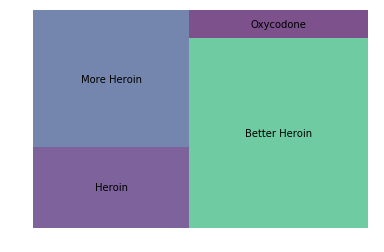

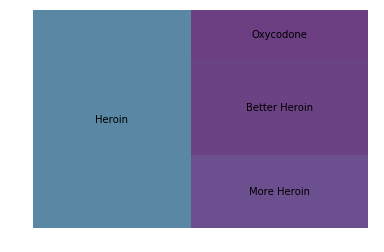

In [24]:
%matplotlib inline



for x in drug_data:
    
 
# If you have 2 lists
squarify.plot(sizes=[13,22,35,5], label=["Heroin", "More Heroin", "Better Heroin", "Oxycodone"], alpha=.7 )
plt.axis('off')
plt.show()
 
# If you have a data frame?
df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["Heroin", "More Heroin", "Better Heroin", "Oxycodone"] })
squarify.plot(sizes=df['nb_people'], label=df['group'], alpha=.8 )
plt.axis('off')
plt.show() 

Text(0.5, 1.0, 'Sankey diagram with default settings')

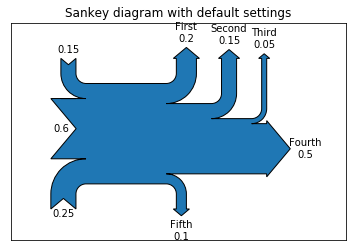

In [25]:
 # basic sankey chart
Sankey(flows=[0.25, 0.15, 0.60, -0.20, -0.15, -0.05, -0.50, -0.10], labels=['', '', '', 'First', 'Second', 'Third', 'Fourth', 'Fifth'], orientations=[-1, 1, 0, 1, 1, 1, 0,-1]).finish()
plt.title("Sankey diagram with default settings")

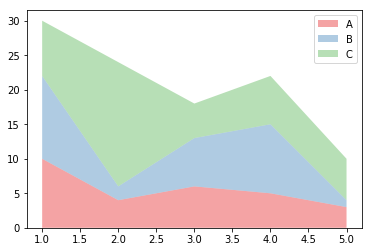

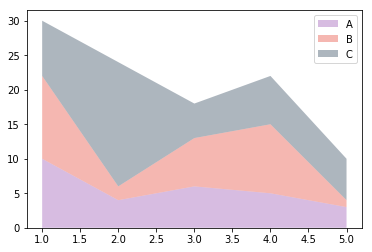

In [26]:
# Your x and y axis
x=range(1,6)
y=[ [10,4,6,5,3], [12,2,7,10,1], [8,18,5,7,6] ]
 
# use a known color palette (see..)
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')

/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  This is separate from the ipykernel package so we can avoid doing imports until


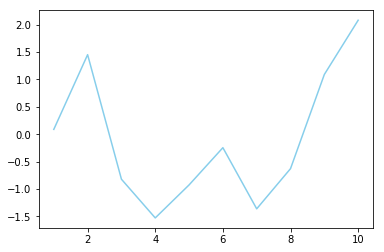

In [27]:
%matplotlib inline
df=pd.DataFrame({'x': range(1,11), 'y': np.random.randn(10) })
plt.plot( 'x', 'y', data=df, color='skyblue')
plt.show()